In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure plots display in Jupyter Notebook
%matplotlib inline

# Set up plotting style
sns.set(style="whitegrid")

# --- Step 0: Load and Prepare Data ---

# Define the columns needed from each file to optimize memory usage.
# This list includes all columns required for cleaning, transformations, and creating dimensions.
accidents_cols = [
    'Accident_Index', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles',
    'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)',
    '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
    'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number',
    'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities',
    'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
    'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area',
    'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location'
]

casualties_cols = [
    'Accident_Index', 'Vehicle_Reference', 'Casualty_Reference', 'Casualty_Class',
    'Sex_of_Casualty', 'Age_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity',
    'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger',
    'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker',
    'Casualty_Type', 'Casualty_Home_Area_Type'
]

# Load the datasets
# Note: Ensure the CSV files are in a './data/' subfolder or update the path.
try:
    accidents_df = pd.read_csv("./data/Accidents0515.csv", usecols=accidents_cols, low_memory=False)
    casualties_df = pd.read_csv("./data/Casualties0515.csv", usecols=casualties_cols, low_memory=False)
except FileNotFoundError:
    print("Error: Make sure 'Accidents0515.csv' and 'Casualties0515.csv' are in the './data/' directory.")
    # Exit or create dummy data if you want the script to run without the files
    # For this demonstration, we'll stop here if files are not found.
    exit()


# --- Step 1: Data Cleaning and Pre-processing ---

# Coerce date/time columns to datetime objects, handling errors
accidents_df['Date'] = pd.to_datetime(accidents_df['Date'], format='%d/%m/%Y', errors='coerce')
accidents_df['Hour'] = pd.to_datetime(accidents_df['Time'], format='%H:%M', errors='coerce').dt.hour

# Drop rows where essential data for dimensions or facts is missing
accidents_df.dropna(
    subset=['Accident_Index', 'Date', 'Hour', 'Police_Force', 'Local_Authority_(District)', 'Road_Type', 'Weather_Conditions', 'Urban_or_Rural_Area'],
    inplace=True
)
casualties_df.dropna(subset=['Accident_Index', 'Casualty_Severity', 'Age_Band_of_Casualty'], inplace=True)


# --- Step 2: Create Dimension Tables ---

# --- Dim_Time ---
time_df = accidents_df[['Date', 'Hour']].copy().drop_duplicates()
time_df['Year'] = time_df['Date'].dt.year
time_df['Quarter'] = time_df['Date'].dt.quarter
time_df['Month'] = time_df['Date'].dt.month
time_df['Month_Name'] = time_df['Date'].dt.month_name()
time_df['Day_of_Week'] = time_df['Date'].dt.day_name()
time_df['Time_of_Day'] = pd.cut(time_df['Hour'],
                                bins=[-1, 5, 11, 17, 23],
                                labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                ordered=True)

# Create hierarchy: Year -> Quarter -> Month -> Date -> Hour
dim_year = time_df[['Year']].drop_duplicates().sort_values('Year').reset_index(drop=True)
dim_year['Year_ID'] = dim_year.index + 1

dim_quarter = time_df[['Year', 'Quarter']].drop_duplicates().sort_values(['Year', 'Quarter']).reset_index(drop=True)
dim_quarter['Quarter_ID'] = dim_quarter.index + 1

dim_month = time_df[['Year', 'Quarter', 'Month', 'Month_Name']].drop_duplicates().sort_values(['Year', 'Month']).reset_index(drop=True)
dim_month['Month_ID'] = dim_month.index + 1

dim_date = time_df[['Date', 'Year', 'Month', 'Day_of_Week']].drop_duplicates().sort_values('Date').reset_index(drop=True)
dim_date['Date_ID'] = dim_date.index + 1

dim_hour = time_df[['Hour', 'Time_of_Day']].drop_duplicates().sort_values('Hour').reset_index(drop=True)
dim_hour['Hour_ID'] = dim_hour.index + 1

# --- Dim_Location ---
# Mapping for Urban/Rural Area
accidents_df['Urban_or_Rural_Area_Name'] = accidents_df['Urban_or_Rural_Area'].map({1: 'Urban', 2: 'Rural', 3: 'Unallocated'}).fillna('Unknown')
location_df = accidents_df[['Police_Force', 'Local_Authority_(District)', 'Urban_or_Rural_Area', 'Urban_or_Rural_Area_Name']].drop_duplicates()

dim_police_force = location_df[['Police_Force']].drop_duplicates().sort_values('Police_Force').reset_index(drop=True)
dim_police_force['Police_Force_ID'] = dim_police_force.index + 1

dim_local_authority = location_df[['Police_Force', 'Local_Authority_(District)']].drop_duplicates().sort_values(['Police_Force', 'Local_Authority_(District)']).reset_index(drop=True)
dim_local_authority['Local_Authority_ID'] = dim_local_authority.index + 1

dim_location = location_df[['Local_Authority_(District)', 'Urban_or_Rural_Area', 'Urban_or_Rural_Area_Name']].drop_duplicates().reset_index(drop=True)
dim_location['Location_ID'] = dim_location.index + 1

# --- Dim_Road ---
road_type_mapping = {1: 'Roundabout', 2: 'One way street', 3: 'Dual carriageway', 6: 'Single carriageway', 7: 'Slip road', 9: 'Unknown', 12: 'One way street/Slip road', -1: 'Unknown'}
accidents_df['Road_Type_Name'] = accidents_df['Road_Type'].map(road_type_mapping).fillna('Unknown')
dim_road_type = accidents_df[['Road_Type', 'Road_Type_Name']].drop_duplicates().sort_values('Road_Type').reset_index(drop=True)
dim_road_type['Road_Type_ID'] = dim_road_type.index + 1

# --- Dim_Weather ---
weather_mapping = {1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or mist', 8: 'Other', 9: 'Unknown', -1: 'Unknown'}
accidents_df['Weather_Condition_Name'] = accidents_df['Weather_Conditions'].map(weather_mapping).fillna('Unknown')
dim_weather = accidents_df[['Weather_Conditions', 'Weather_Condition_Name']].drop_duplicates().sort_values('Weather_Conditions').reset_index(drop=True)
dim_weather['Weather_ID'] = dim_weather.index + 1

# --- Dim_Casualty ---
age_band_mapping = {1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75', -1: 'Unknown'}
casualties_df['Age_Band_Name'] = casualties_df['Age_Band_of_Casualty'].map(age_band_mapping).fillna('Unknown')
dim_age_band = casualties_df[['Age_Band_of_Casualty', 'Age_Band_Name']].drop_duplicates().sort_values('Age_Band_of_Casualty').reset_index(drop=True)
dim_age_band['Age_Band_ID'] = dim_age_band.index + 1


# --- Step 3: Create Fact Table ---

# Aggregate casualty data to get total count and most severe outcome per accident
casualty_agg = casualties_df.groupby('Accident_Index').agg(
    Casualty_Count=('Casualty_Reference', 'count'),
    Most_Severe_Casualty=('Casualty_Severity', 'min') # 1=Fatal is min, 3=Slight is max
).reset_index()

# Start building the fact table from the main accidents dataframe
fact_accident = accidents_df[['Accident_Index', 'Date', 'Hour', 'Police_Force', 'Local_Authority_(District)', 'Urban_or_Rural_Area', 'Road_Type', 'Weather_Conditions']].copy()

# Merge with aggregated casualty data
fact_accident = fact_accident.merge(casualty_agg, on='Accident_Index', how='left')
fact_accident['Casualty_Count'].fillna(0, inplace=True)
fact_accident['Most_Severe_Casualty'].fillna(3, inplace=True) # Assume 'Slight' if no casualty info

# --- Step 4: Link Fact Table with Dimension Keys ---

# Link Time Dimensions
fact_accident = fact_accident.merge(dim_date[['Date', 'Date_ID']], on='Date')
fact_accident = fact_accident.merge(dim_hour[['Hour', 'Hour_ID']], on='Hour')

# Link Location Dimension
fact_accident = fact_accident.merge(
    dim_location[['Location_ID', 'Local_Authority_(District)', 'Urban_or_Rural_Area']],
    on=['Local_Authority_(District)', 'Urban_or_Rural_Area']
)

# Link Road and Weather Dimensions
fact_accident = fact_accident.merge(dim_road_type[['Road_Type_ID', 'Road_Type']], on='Road_Type')
fact_accident = fact_accident.merge(dim_weather[['Weather_ID', 'Weather_Conditions']], on='Weather_Conditions')

# Select final columns for the fact table
fact_accident = fact_accident[[
    'Accident_Index', 'Date_ID', 'Hour_ID', 'Location_ID',
    'Road_Type_ID', 'Weather_ID', 'Casualty_Count', 'Most_Severe_Casualty'
]].rename(columns={'Accident_Index': 'Accident_ID'})


# --- Step 5: Create a Separate Fact Table for Casualties ---
# This is a better approach than summarizing casualties into the accident fact table
# for questions related to casualty demographics.

fact_casualty = casualties_df[['Accident_Index', 'Age_Band_of_Casualty', 'Sex_of_Casualty', 'Casualty_Type']].copy()
fact_casualty = fact_casualty.merge(dim_age_band[['Age_Band_ID', 'Age_Band_of_Casualty']], on='Age_Band_of_Casualty')
fact_casualty = fact_accident[['Accident_ID', 'Date_ID', 'Location_ID']].merge(fact_casualty, left_on='Accident_ID', right_on='Accident_Index')
fact_casualty = fact_casualty[['Accident_ID', 'Date_ID', 'Location_ID', 'Age_Band_ID', 'Sex_of_Casualty', 'Casualty_Type']]


# --- Step 6: Save Tables to CSV ---
# (This step is optional but good practice)
fact_accident.to_csv('fact_accident.csv', index=False)
fact_casualty.to_csv('fact_casualty.csv', index=False)
dim_date.to_csv('dim_date.csv', index=False)
dim_hour.to_csv('dim_hour.csv', index=False)
dim_location.to_csv('dim_location.csv', index=False)
dim_road_type.to_csv('dim_road_type.csv', index=False)
dim_weather.to_csv('dim_weather.csv', index=False)
dim_age_band.to_csv('dim_age_band.csv', index=False)

print("Step 6: Snowflake schema tables generated and saved as CSV files.")


# --- Step 7: Answer Analytical Questions ---

# Question 1: Which times of day have the most accidents?
plt.figure(figsize=(10, 6))
df1 = fact_accident.merge(dim_hour, on='Hour_ID')
pivot1 = df1.groupby('Time_of_Day')['Accident_ID'].count().reset_index(name='Accident_Count').sort_values('Accident_Count', ascending=False)
sns.barplot(x='Time_of_Day', y='Accident_Count', data=pivot1, palette='Blues_d', order=pivot1['Time_of_Day'])
plt.title('Accidents by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Accidents')
plt.savefig('accidents_by_time_of_day.png')
plt.show()
print("Question 1 Results: Times of Day with Most Accidents")
print(pivot1)
print("\n")

# Question 2: Which days of the week have the most accidents?
plt.figure(figsize=(10, 6))
df2 = fact_accident.merge(dim_date, on='Date_ID')
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot2 = df2.groupby('Day_of_Week')['Accident_ID'].count().reindex(day_order).reset_index(name='Accident_Count')
sns.barplot(x='Day_of_Week', y='Accident_Count', data=pivot2, palette='Greens_d')
plt.title('Accidents by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.savefig('accidents_by_day_of_week.png')
plt.show()
print("Question 2 Results: Days of Week with Most Accidents")
print(pivot2)
print("\n")

# Question 3: How do weather conditions influence the frequency or severity of accidents?
plt.figure(figsize=(12, 6))
df3 = fact_accident.merge(dim_weather, on='Weather_ID')
pivot3 = df3.groupby('Weather_Condition_Name').agg(
    Accident_Count=('Accident_ID', 'count'),
    Avg_Severity=('Most_Severe_Casualty', 'mean')
).sort_values('Accident_Count', ascending=False).reset_index()
sns.barplot(x='Weather_Condition_Name', y='Accident_Count', data=pivot3, palette='Oranges_d')
plt.title('Accidents by Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('accidents_by_weather_conditions.png')
plt.show()
print("Question 3 Results: Weather Conditions Impact on Accidents")
print(pivot3)
print("\n")

# Question 4: Which geographical areas (e.g., based on police force or urban/rural) have the highest accident rate?
plt.figure(figsize=(14, 7))
# To answer this, we need to join multiple dimension tables
df4_temp = fact_accident.merge(dim_location, on='Location_ID')\
                        .merge(dim_local_authority, on='Local_Authority_(District)')\
                        .merge(dim_police_force, on='Police_Force')
pivot4 = df4_temp.groupby(['Police_Force', 'Urban_or_Rural_Area_Name'])['Accident_ID'].count().reset_index(name='Accident_Count')
pivot4_sorted = pivot4.sort_values('Accident_Count', ascending=False)
top_20_forces_by_accident_count = pivot4.groupby('Police_Force')['Accident_Count'].sum().nlargest(20).index
pivot4_top20 = pivot4[pivot4['Police_Force'].isin(top_20_forces_by_accident_count)]
sns.barplot(data=pivot4_top20, x='Police_Force', y='Accident_Count', hue='Urban_or_Rural_Area_Name', palette='Purples_d')
plt.title('Top 20 Police Forces by Accident Count and Area Type')
plt.xlabel('Police Force')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('accidents_by_geographical_area.png')
plt.show()
print("Question 4 Results: Geographical Areas with Highest Accident Rates (Top 20 Police Forces)")
print(pivot4_sorted.head(20))
print("\n")


# Question 5: Which road type has the most accidents?
plt.figure(figsize=(10, 6))
df5 = fact_accident.merge(dim_road_type, on='Road_Type_ID')
pivot5 = df5.groupby('Road_Type_Name')['Accident_ID'].count().sort_values(ascending=False).reset_index(name='Accident_Count')
sns.barplot(x='Road_Type_Name', y='Accident_Count', data=pivot5, palette='Reds_d')
plt.title('Accidents by Road Type')
plt.xlabel('Road Type')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('accidents_by_road_type.png')
plt.show()
print("Question 5 Results: Road Types with Most Accidents")
print(pivot5)
print("\n")

# Question 6: Which age groups have the most casualties in accidents?
plt.figure(figsize=(10, 6))
# Use the fact_casualty table for this question
df6 = fact_casualty.merge(dim_age_band, on='Age_Band_ID')
pivot6 = df6['Age_Band_Name'].value_counts().reset_index()
pivot6.columns = ['Age_Band_Name', 'Casualty_Count']
# Sort by a logical age order instead of count for better interpretation
age_order = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-35', '36-45', '46-55', '56-65', '66-75', 'Over 75', 'Unknown']
pivot6['Age_Band_Name'] = pd.Categorical(pivot6['Age_Band_Name'], categories=age_order, ordered=True)
pivot6 = pivot6.sort_values('Age_Band_Name')
sns.barplot(x='Age_Band_Name', y='Casualty_Count', data=pivot6, palette='viridis')
plt.title('Total Casualties by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Number of Casualties')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('casualties_by_age_group.png')
plt.show()
print("Question 6 Results: Age Groups with Most Casualties")
print(pivot6)
print("\n")

print("All analyses complete. Visualizations saved as PNG files.")

Step 6: Snowflake schema tables generated and saved as CSV files.


C:\Users\timsc\AppData\Local\Temp\ipykernel_14236\3266478178.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Time_of_Day', y='Accident_Count', data=pivot1, palette='Blues_d', order=pivot1['Time_of_Day'])


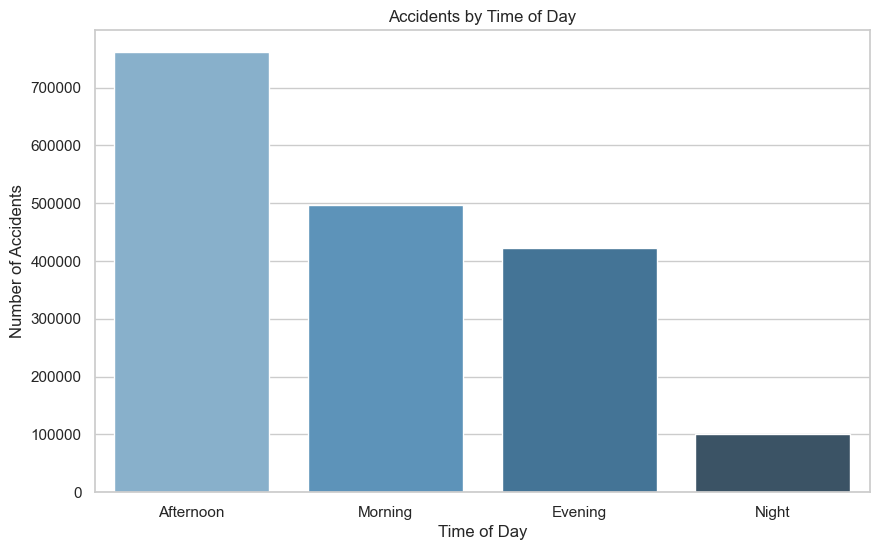

Question 1 Results: Times of Day with Most Accidents
  Time_of_Day  Accident_Count
2   Afternoon          761137
1     Morning          497037
3     Evening          422138
0       Night          100190




C:\Users\timsc\AppData\Local\Temp\ipykernel_14236\3266478178.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Day_of_Week', y='Accident_Count', data=pivot2, palette='Greens_d')


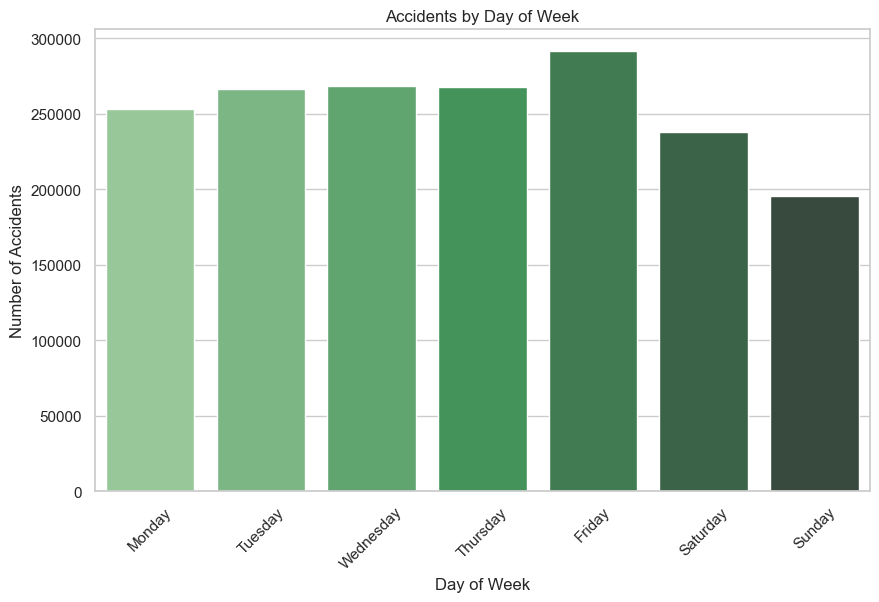

Question 2 Results: Days of Week with Most Accidents
  Day_of_Week  Accident_Count
0      Monday          253250
1     Tuesday          266681
2   Wednesday          268362
3    Thursday          267470
4      Friday          291343
5    Saturday          238087
6      Sunday          195309




C:\Users\timsc\AppData\Local\Temp\ipykernel_14236\3266478178.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weather_Condition_Name', y='Accident_Count', data=pivot3, palette='Oranges_d')


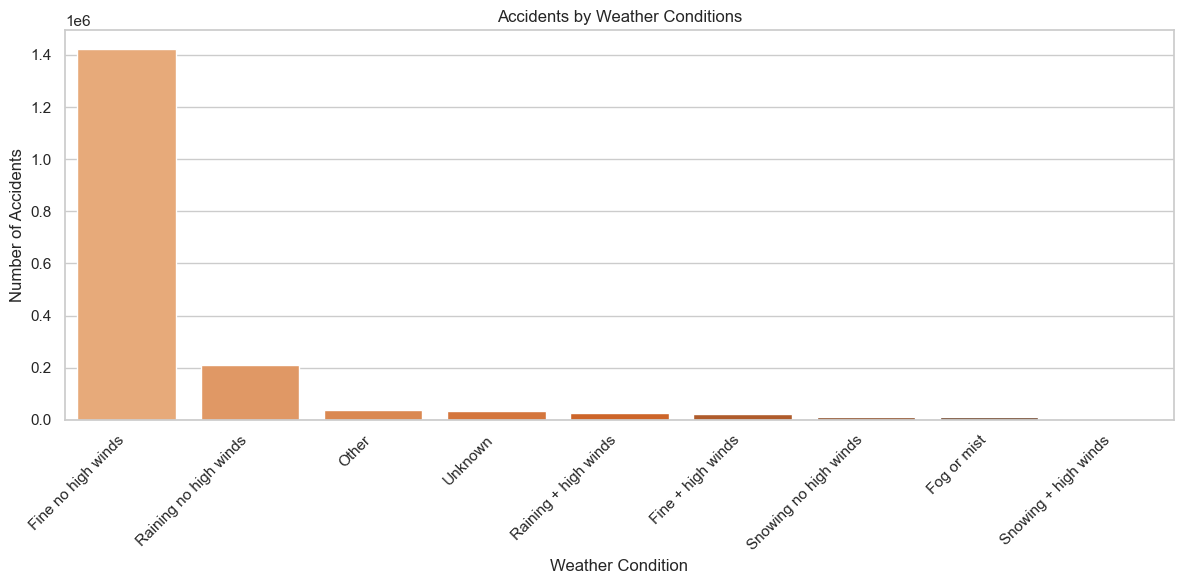

Question 3 Results: Weather Conditions Impact on Accidents
  Weather_Condition_Name  Accident_Count  Avg_Severity
0     Fine no high winds         1423032      2.833300
1  Raining no high winds          210475      2.857698
2                  Other           39159      2.872418
3                Unknown           34268      2.887913
4   Raining + high winds           25852      2.838775
5      Fine + high winds           23311      2.813350
6  Snowing no high winds           12400      2.886694
7            Fog or mist            9697      2.813447
8   Snowing + high winds            2308      2.868718




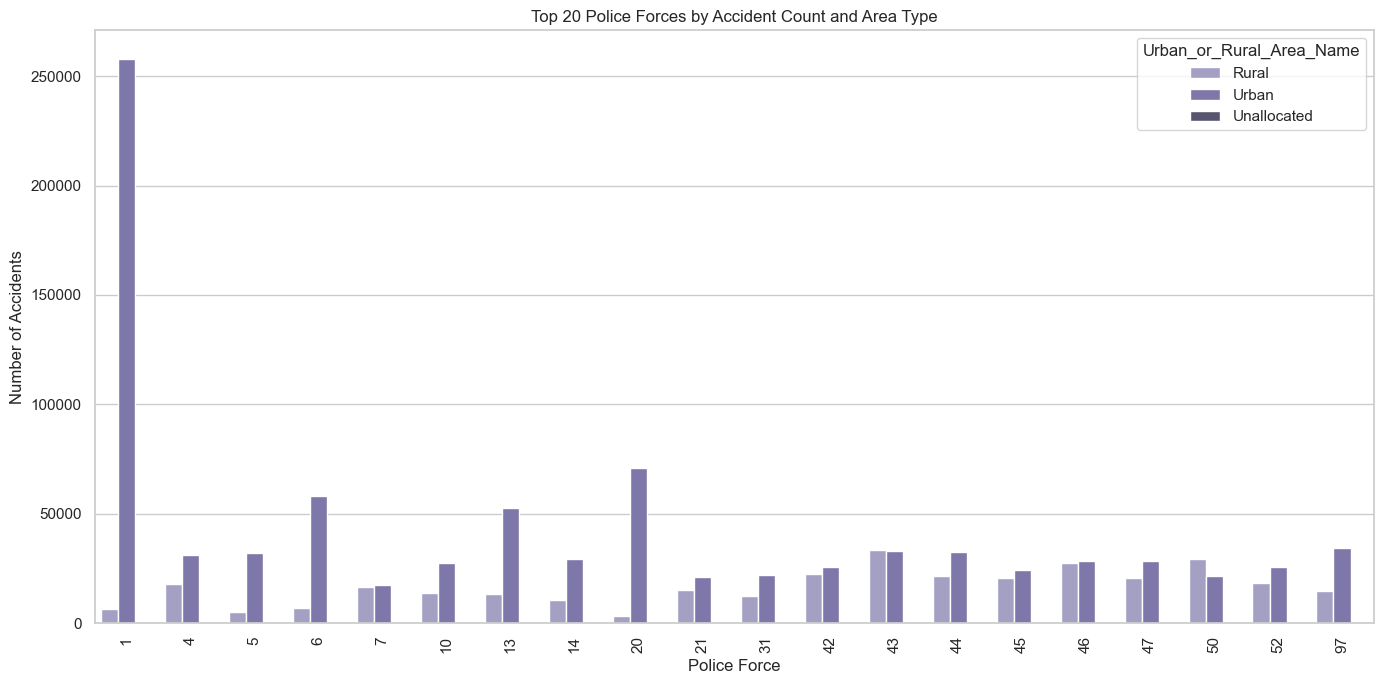

Question 4 Results: Geographical Areas with Highest Accident Rates (Top 20 Police Forces)
     Police_Force Urban_or_Rural_Area_Name  Accident_Count
1               1                    Urban          257961
31             20                    Urban           71041
11              6                    Urban           58021
22             13                    Urban           52442
115            97                    Urban           34466
60             43                    Rural           33301
61             43                    Urban           32807
64             44                    Urban           32581
9               5                    Urban           32267
6               4                    Urban           31408
74             50                    Rural           29500
25             14                    Urban           29481
68             46                    Urban           28518
71             47                    Urban           28290
67             46        

C:\Users\timsc\AppData\Local\Temp\ipykernel_14236\3266478178.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Road_Type_Name', y='Accident_Count', data=pivot5, palette='Reds_d')


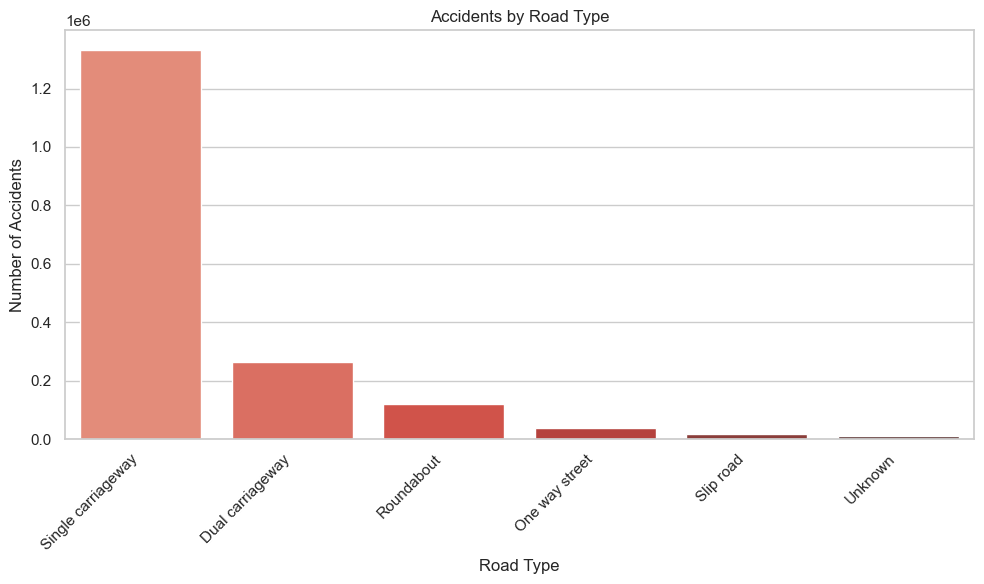

Question 5 Results: Road Types with Most Accidents
       Road_Type_Name  Accident_Count
0  Single carriageway         1332258
1    Dual carriageway          262940
2          Roundabout          119464
3      One way street           36752
4           Slip road           18646
5             Unknown           10442




C:\Users\timsc\AppData\Local\Temp\ipykernel_14236\3266478178.py:288: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Age_Band_Name', y='Casualty_Count', data=pivot6, palette='viridis')


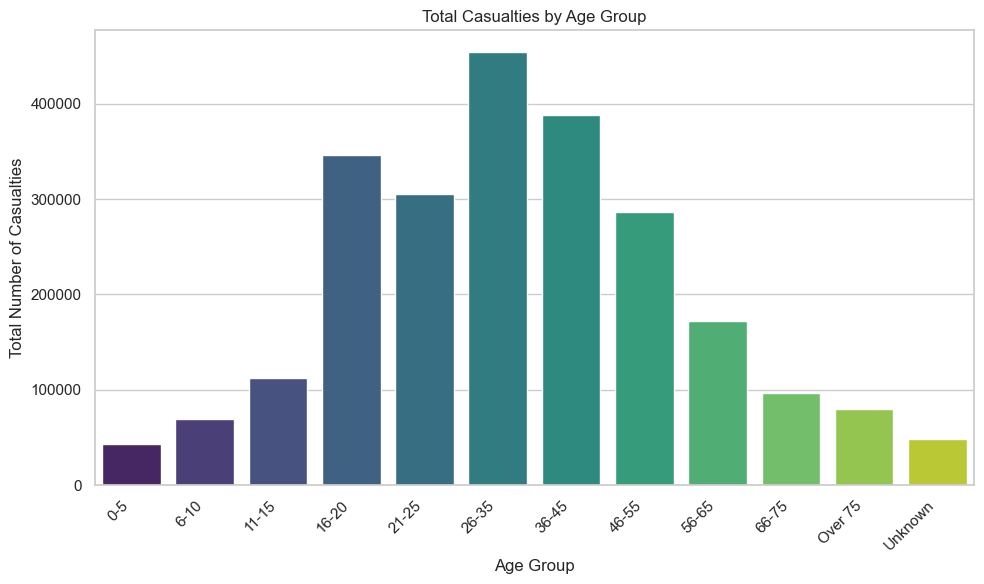

Question 6 Results: Age Groups with Most Casualties
   Age_Band_Name  Casualty_Count
11           0-5           43333
9           6-10           68975
6          11-15          112659
2          16-20          346612
3          21-25          305473
0          26-35          454037
1          36-45          387587
4          46-55          286766
5          56-65          172551
7          66-75           96193
8        Over 75           79635
10       Unknown           48913


All analyses complete. Visualizations saved as PNG files.
